# 完整SMO

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
"""
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Zhihu:
    https://www.zhihu.com/people/Jack--Cui/
Modify:
    2017-10-03
"""
 
class optStruct:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
    """
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
 
def loadDataSet(fileName):
    """
    读取数据
    Parameters:
        fileName - 文件名
    Returns:
        dataMat - 数据矩阵
        labelMat - 数据标签
    """
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat
 
def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T) + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
 
def selectJrand(i, m):
    """
    函数说明:随机选择alpha_j的索引值
 
    Parameters:
        i - alpha_i的索引值
        m - alpha参数个数
    Returns:
        j - alpha_j的索引值
    """
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j
 
def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej
 
def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存
 
 
def clipAlpha(aj,H,L):
    """
    修剪alpha_j
    Parameters:
        aj - alpha_j的值
        H - alpha上限
        L - alpha下限
    Returns:
        aj - 修剪后的alpah_j的值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj
 
def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.X[i,:] * oS.X[j,:].T - oS.X[i,:] * oS.X[i,:].T - oS.X[j,:] * oS.X[j,:].T
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0
 
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    """
    完整的线性SMO算法
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        maxIter - 最大迭代次数
    Returns:
        oS.b - SMO算法计算的b
        oS.alphas - SMO算法计算的alphas
    """
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler)                    #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas
 
 
def showClassifer(dataMat, classLabels, w, b):
    """
    分类结果可视化
    Parameters:
        dataMat - 数据矩阵
        w - 直线法向量
        b - 直线解决
    Returns:
        无
    """
    #绘制样本点
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if classLabels[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1], s=30, alpha=0.7)   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1], s=30, alpha=0.7) #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()
 
 
def calcWs(alphas,dataArr,classLabels):
    """
    计算w
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        alphas - alphas值
    Returns:
        w - 计算得到的w
    """
    X = np.mat(dataArr); labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w
 


L==H
全样本遍历:第0次迭代 样本:0, alpha优化次数:0
L==H
全样本遍历:第0次迭代 样本:1, alpha优化次数:0
全样本遍历:第0次迭代 样本:2, alpha优化次数:1
L==H
全样本遍历:第0次迭代 样本:3, alpha优化次数:1
全样本遍历:第0次迭代 样本:4, alpha优化次数:2
全样本遍历:第0次迭代 样本:5, alpha优化次数:2
全样本遍历:第0次迭代 样本:6, alpha优化次数:2
alpha_j变化太小
全样本遍历:第0次迭代 样本:7, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:8, alpha优化次数:2
全样本遍历:第0次迭代 样本:9, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:10, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:11, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:12, alpha优化次数:2
全样本遍历:第0次迭代 样本:13, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:14, alpha优化次数:2
全样本遍历:第0次迭代 样本:15, alpha优化次数:2
全样本遍历:第0次迭代 样本:16, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:17, alpha优化次数:2
全样本遍历:第0次迭代 样本:18, alpha优化次数:3
全样本遍历:第0次迭代 样本:19, alpha优化次数:3
全样本遍历:第0次迭代 样本:20, alpha优化次数:3
全样本遍历:第0次迭代 样本:21, alpha优化次数:3
alpha_j变化太小
全样本遍历:第0次迭代 样本:22, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:23, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:24, alpha优化次数:3
全样本遍历:第0次迭代 样本:25, alpha优化次数:4
alpha_j变化太小
全样本遍历:第0次迭代 样本:26, alpha优化次数:4
全样本遍历:第0次迭代 样本:27, alpha优化次数:4
全样本遍历:第0次迭代 样本:28, alpha优化次数:4
L==H
全样本遍历:第0次迭代 样本:

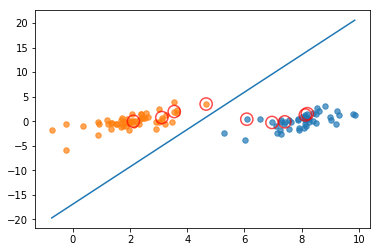

In [7]:
dataArr, classLabels = loadDataSet('testSet.txt')
b, alphas = smoP(dataArr, classLabels, 0.6, 0.001, 40)
w = calcWs(alphas,dataArr, classLabels)
showClassifer(dataArr, classLabels, w, b)

完整版SMO算法选出的支持向量样点更多，更接近理想的分隔超平面。

且完整版SMO算法的速度比简化版SMO算法的速度快6倍左右。